In [553]:
import pandas as pd
import numpy as np

import sklearn as sk
from sklearn import *
from catboost import *
from yellowbrick import *
from sklearn.metrics import *

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [554]:
random_state_all = 25

1. Загрузка массива целей

- Загрузка датасетов

In [555]:
dataset_features = pd.read_csv('Datasets/feature_data_new_mini.csv')
dataset_gs = pd.read_csv('Datasets/goal_cipher.csv')

C:\Users\orlov\AppData\Local\Temp\ipykernel_27272\4035610624.py:1: DtypeWarning: Columns (113,116,119,122,125) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_features = pd.read_csv('Datasets/feature_data_new_mini.csv')


- Предварительная обработка датасетов

- - Удаление дублированных значений

In [556]:
dataset_features.drop_duplicates(inplace = True)
dataset_gs.drop_duplicates(inplace = True)

In [557]:
dataset_features

,ser_loc,zns_loc,prs_loc,year_month,count_fail,107_repair_count,307_repair_count,308_repair_count,309_repair_count,521_repair_count,...,тл-2к_y,тл-2к1,эд118а,эд118б,эдп810,эк-810ч,экг-8ж,power,last_of_p_data,last_of_in_invent
0,107,3.0,1.0,2020-01-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0
1,107,3.0,1.0,2019-03-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0
2,107,4.0,1.0,2020-04-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,0.0,0.0
3,107,4.0,1.0,2020-06-28,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,6.0,6.0
4,107,4.0,1.0,2020-07-28,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167249,693,74.0,3.0,2019-03-28,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2206.0,0.0,0.0
167250,693,74.0,3.0,2021-04-28,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2206.0,51.0,51.0
167251,693,74.0,3.0,2021-05-28,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2206.0,55.0,55.0
167252,693,74.0,3.0,2021-07-28,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2206.0,64.0,64.0


- Вычленение указанных заданием параметров из таблицы

In [558]:
dataset_gs = dataset_gs[dataset_gs['fail_reason'] == 'Личи'].T.iloc()[1 : ].T
dataset_gs.drop(['fail_place', 'fail_reason', 'fail_type'], axis = 1, inplace = True)

In [559]:
dataset_gs

,ser_loc,zns_loc,prs_loc,year_month,day
395,240,1407.0,1.0,2021-01,17
437,240,1773.0,1.0,2021-01,5
500,240,1571.0,1.0,2021-01,10
553,240,529.0,1.0,2021-01,2
881,240,653.0,1.0,2021-01,25
...,...,...,...,...,...
52663,233,1656.0,1.0,2018-09,8
52669,226,2006.0,2.0,2018-09,1
52686,233,1645.0,1.0,2018-09,8
52704,240,1435.0,2.0,2018-09,10


- Перевод всех названий столбцов в нижний регистр

In [560]:
dataset_features.columns = [name.lower() for name in dataset_features.columns]
dataset_gs.columns = [name.lower() for name in dataset_gs.columns]

- Преобразовывание дат в соответствующий формат

In [561]:
dataset_gs['year_month'] = pd.to_datetime(dataset_gs['year_month']).dt.to_period('M')
dataset_features['year_month'] = pd.to_datetime(dataset_features['year_month']).dt.to_period('M')

In [562]:
print(dataset_features.year_month.iloc()[:10], '\n\n\n', dataset_gs.year_month.iloc()[:10])

0    2020-01
1    2019-03
2    2020-04
3    2020-06
4    2020-07
5    2020-09
6    2020-01
7    2020-03
8    2019-10
9    2020-09
Name: year_month, dtype: period[M] 


 395     2021-01
437     2021-01
500     2021-01
553     2021-01
881     2021-01
1049    2021-01
1466    2020-12
1664    2020-12
1698    2020-12
1862    2020-12
Name: year_month, dtype: period[M]


2. Объеднинение массива целей с массивом признаков

- Слияние датасетов в один по указанным ключам

In [563]:
dataset_merged = dataset_features.merge(dataset_gs, on = ['ser_loc','zns_loc','prs_loc','year_month'], how = 'outer')

C:\Users\orlov\AppData\Local\Temp\ipykernel_27272\4030675962.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dataset_merged = dataset_features.merge(dataset_gs, on = ['ser_loc','zns_loc','prs_loc','year_month'], how = 'outer')


In [564]:
dataset_merged

,ser_loc,zns_loc,prs_loc,year_month,count_fail,107_repair_count,307_repair_count,308_repair_count,309_repair_count,521_repair_count,...,тл-2к1,эд118а,эд118б,эдп810,эк-810ч,экг-8ж,power,last_of_p_data,last_of_in_invent,day
0,107.0,3.0,1.0,2020-01,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0,NaN
1,107.0,3.0,1.0,2019-03,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3250.0,0.0,0.0,NaN
2,107.0,4.0,1.0,2020-04,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,0.0,0.0,NaN
3,107.0,4.0,1.0,2020-06,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,6.0,6.0,NaN
4,107.0,4.0,1.0,2020-07,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3080.0,10.0,10.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166331,233,1656.0,1.0,2018-09,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
166332,226,2006.0,2.0,2018-09,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
166333,233,1645.0,1.0,2018-09,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
166334,240,1435.0,2.0,2018-09,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


3. Обработка пропусков после объединения

- Убираем пустые занчения в строках, в которых значения в столбце "count_fail" == NaN

In [565]:
dataset_merged.dropna(subset = ['count_fail'], inplace = True)

- Убираем неиспользуемые столбцы из датасета

In [566]:
dataset_merged.drop(['date_repair_finish_y_1', 'date_repair_finish_x_2', 'date_repair_finish_y_2', 'date_repair_finish', 'date_repair_finish_x_1'], axis = 1, inplace = True)

4. Выбрать метод обучения

- Создание модели классификатора. Используем CatBoost

In [567]:
iterations = 100
learn_rate = 0.2
loss_fun = 'CrossEntropy'

model = CatBoostClassifier(
    iterations = iterations, 
    learning_rate = learn_rate,
    loss_function = loss_fun
    )

5. Преобразование целевых меток

- Заменям значения дней на 1, если не NaN, иначе - 0

- - Заменяем NaN во всей таблице на 0

- - Устанавливаем 4 значения в качестве индексов (3 первых потому, что они не являются признаками, определяющими информацию в датасете. По последнему сопоставляются данные)

In [568]:
dataset_merged['day'] = [1 if day_val > 0 else 0 for day_val in dataset_merged['day']]
dataset_merged.fillna(0, inplace = True)
dataset_marked = dataset_merged.set_index(['ser_loc','zns_loc','prs_loc','year_month'])

6. Инженерия данных

* Демонстрация необходиомсти балансировки

In [569]:
dataset_marked.day.value_counts()

0    165648
1        99
Name: day, dtype: int64

- - Общее число единиц и нулей явно сильно разнится

- Нормализация данных в датасете

In [573]:
arr_scaled = MinMaxScaler().fit_transform(dataset_marked)
dataset_marked = pd.DataFrame(arr_scaled, columns=dataset_marked.columns, index=dataset_marked.index)

- Разделение датасета на 'Х' - параметры - и 'у' - значения, соответствующие определенным параметрам в таблице

In [574]:
X = dataset_marked.drop(columns=['day'])
y = dataset_marked[['day']]

- Применяем балансировку по причине того, что в столбце "day" наблюдается явный дисбаланас единиц и нулей, который не позволит модели адекватно обучиться.

- - Разбиваем сбалансированные данные на две выборки - тестовую (суффикс test) и тренировочную (суффикс train) в пропорции 4 части датасета - тестовые данные - на 6 частей - тренировочная.
Отмечу, что была сбалансирована лишь тренировочная выборка - тестовая только нормирована. Так мы сможем увидеть поведение получившейся модели на реальных данных

In [575]:
sm = SMOTE(random_state=random_state_all, k_neighbors=5)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.4, random_state=random_state_all)

X_res, y_res = sm.fit_resample(X_train, y_train)

- - Результат балансировки

In [638]:
pd.DataFrame(y_train.value_counts()).reset_index().set_index('day').rename(columns = {0 : 'y_test_count'}).join(pd.DataFrame(y_res.value_counts()).reset_index().set_index('day').rename(columns = {0 : 'y_resampled_count'}), rsuffix = '_resampled')

,y_test_count,y_resampled_count
day,,
0.0,165648,165648
1.0,165648,165648


In [636]:
X_train, y_train = X_res, y_res

- Проводим обучение модели на  и нормированных данных

- - Обучение модели в 1000 итераций на процессоре AMD ryzen 5 5600x заняло полминуты. Будьте осторожны

In [579]:
model = model.fit(
    X_train,
    y_train,
    eval_set = (X_test, y_test),
    verbose = False
    )

- Даем модели предсказать значения "у" на параметрах, описанных в "X_test". Это позволит оценить точность предсказаний получившейся модели путем сравнения полученных данных с "y_test"

In [580]:
y_pred_classifier = model.predict(X_test)

- Создаем датасет для удобной работы с получившимися данными и их оценки

In [581]:
model_comparison = pd.DataFrame(y_test)
model_comparison.rename(columns = {'day' : 'day_test'}, inplace = True)

model_comparison = model_comparison.reset_index().drop(model_comparison.reset_index().columns[ : -1], axis = 1)
model_comparison = model_comparison.join(pd.DataFrame(y_pred_classifier, columns = ['day_pred']))

In [582]:
model_comparison

,day_test,day_pred
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
...,...,...
66294,0.0,0
66295,0.0,0
66296,0.0,0
66297,0.0,0


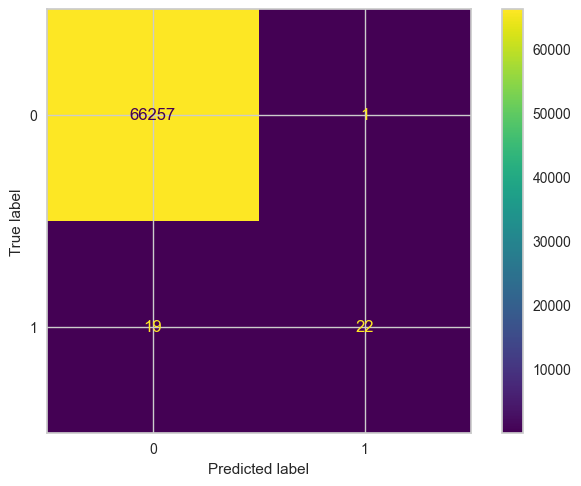

In [583]:
confusion_matrix_plot = confusion_matrix(model_comparison.day_test, model_comparison.day_pred, labels=model.classes_)
confusion_matrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_plot, display_labels=model.classes_)
confusion_matrix_display.plot()

In [584]:
def f1_score_selfmade(confusion_matrix_inner):
    true_negative, false_positive, false_negative, true_positive = confusion_matrix_inner.ravel()
    precission = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)

    return(2 * (precission * recall) / (precission + recall))

In [585]:
print(f'''F1 score selfmade - {f1_score_selfmade(confusion_matrix_plot)}
F1 score integrated - {metrics.f1_score(y_test['day_test'], y_pred_classifier)}
ROC AUC integrated - {metrics.roc_auc_score(y_test['day_test'], y_pred_classifier)}
''')

F1 score selfmade - 0.6875000000000001
F1 score ontegrated - 0.6875000000000001
ROC AUC integrated - 0.7682851366682641

